In [ ]:
# house prices dataset 
# https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

# 
# ! pip install boruta

   ---------------------------------------- 0.0/57.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/57.9 kB ? eta -:--:--
   ---------------------------- ----------- 41.0/57.9 kB 1.9 MB/s eta 0:00:01
   ---------------------------- ----------- 41.0/57.9 kB 1.9 MB/s eta 0:00:01
   ---------------------------------------- 57.9/57.9 kB 507.1 kB/s eta 0:00:00



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


importing needed libraries 

In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from boruta import BorutaPy

from scipy import stats

loading data

In [4]:
row_data = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
print(row_data.shape)
print(row_data.columns)

(1460, 81)
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 

---
# Preprocessing stage 1 (Specifically Data Cleaning): 

1. Handle duplicates 
2. dropping IID columns 
3. typos & misspelling
4. ---- (univariant analysis here then resume data preprocessing) ----- 
5. Missing Values 

---

## 1. Removing duplicates 


In [5]:
pre1 = row_data.copy()
print("shape before dropping duplicates: ", pre1.shape)
pre1.drop_duplicates(inplace=True)
print("shape after dropping duplicates: ", pre1.shape)
# no  duplicates found 

shape before dropping duplicates:  (1460, 81)
shape after dropping duplicates:  (1460, 81)


## 2. Dropping IID columns 

In [6]:
#  Id, it seems only the id column is the only IID column to be removed. 
pre2 = pre1.copy()
print("Shape before dropping IID columns: ", pre2.shape)
pre2 = pre2.drop(['Id'], axis=1)
print("Shape after dropping IID columns: ", pre2.shape)
# pre2.shape


Shape before dropping IID columns:  (1460, 81)
Shape after dropping IID columns:  (1460, 80)


## 3. Univariate Analysis
diplaying categorical features in the form of pie charts and numerical features in the form of histogram

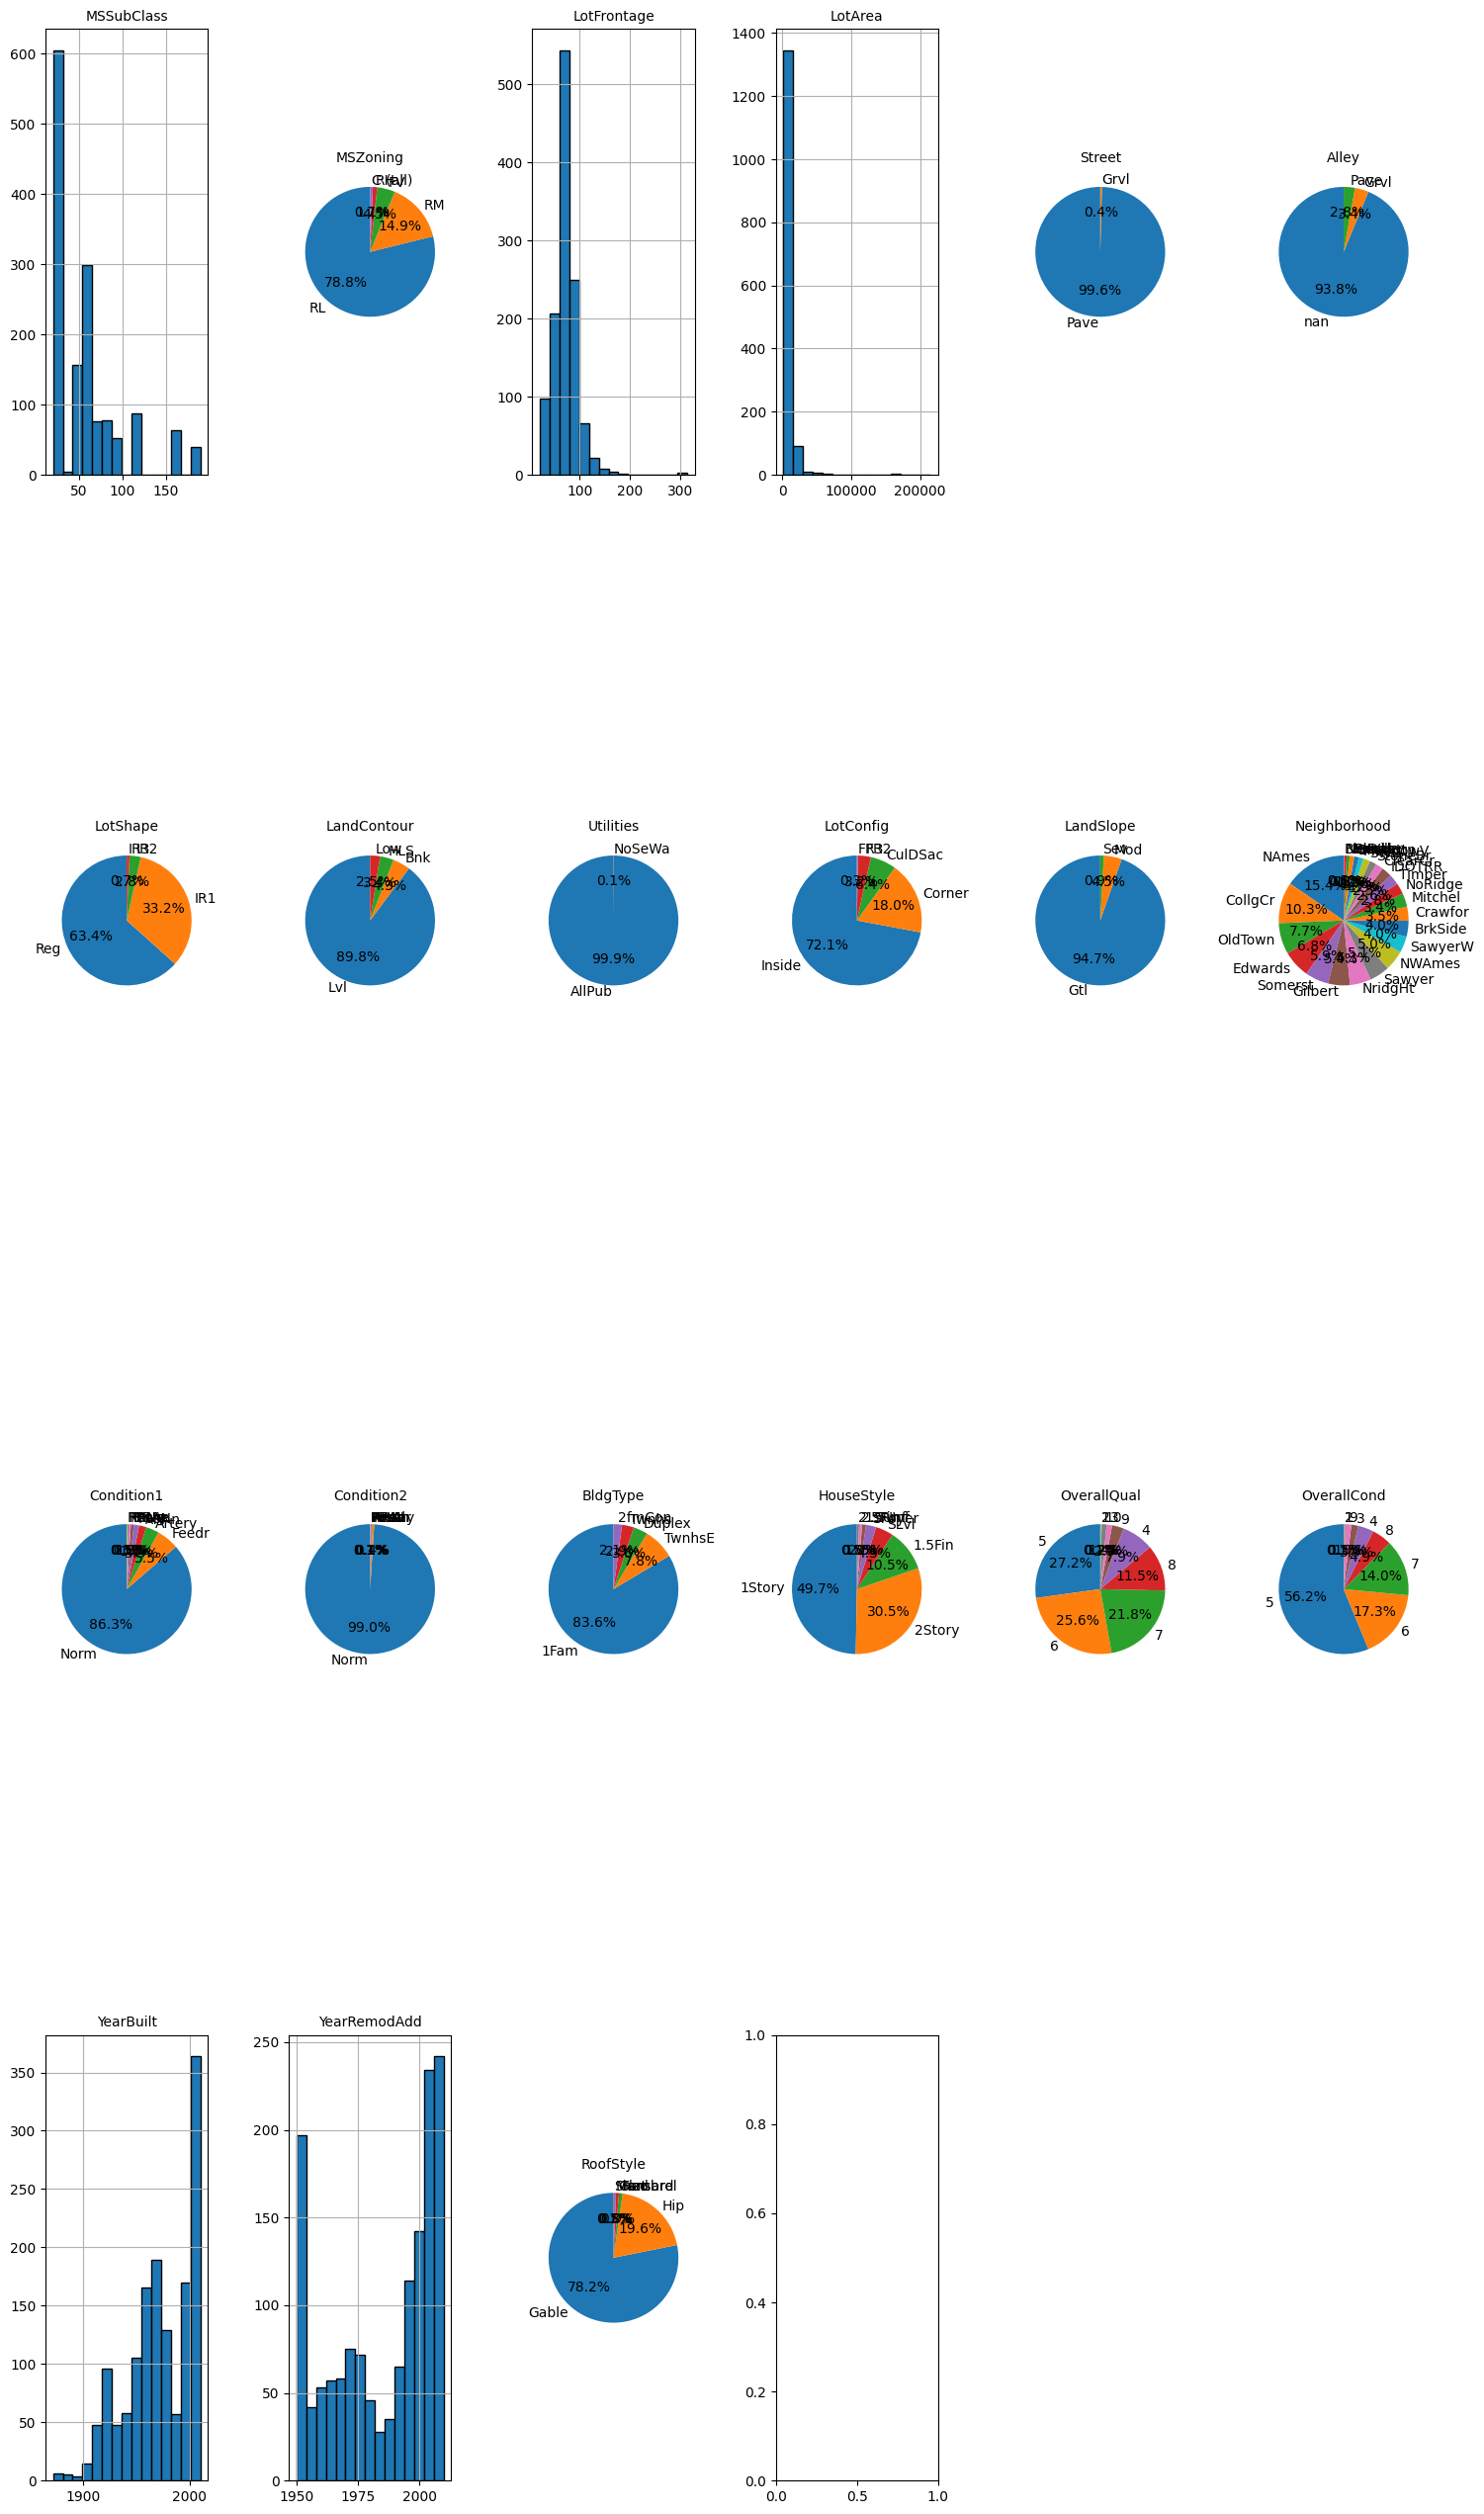

In [8]:
pre3 = pre2.copy()
# Assuming 'test' is your DataFrame

# Set up the figure size and layout (adjust ncols and figsize as needed)
fig, axes = plt.subplots(nrows=len(pre3.columns) // 6 + 1, ncols=6, figsize=(18, len(pre3.columns) * 1.5))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Iterate over columns and plot accordingly
for i, column in enumerate(pre3.columns):
    if (i > 20): 
        break
    if pd.api.types.is_numeric_dtype(pre3[column]) and len(pre3[column].unique()) > 10:
        # Plot histogram for numeric columns with more than 10 unique values
        pre3[column].hist(ax=axes[i], bins=15, edgecolor='black')
        axes[i].set_title(column, fontsize=10)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
    else:
        # Plot pie chart for categorical columns or columns with limited unique values
        value_counts = pre3[column].value_counts(dropna=False)
        axes[i].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
        axes[i].set_title(column, fontsize=10)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

Discussing some features: 
- almost all streets are paved. (more than 90%)
- Around 90% of all Garage Qualities are "TA" which is typical / average. 

As viewed from the above graphs, there are features having a value contributing with almost more than 70% of all the instances in the column values. <br> Which is better to drop them.

Dropped columns: ['MSZoning', 'Street', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'RoofStyle', 'RoofMatl', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'BsmtFinSF2', 'Heating', 'CentralAir', 'Electrical', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SaleType', 'SaleCondition'] 
 
32  columns were dropped form the dataset.  
 
(1460, 48)


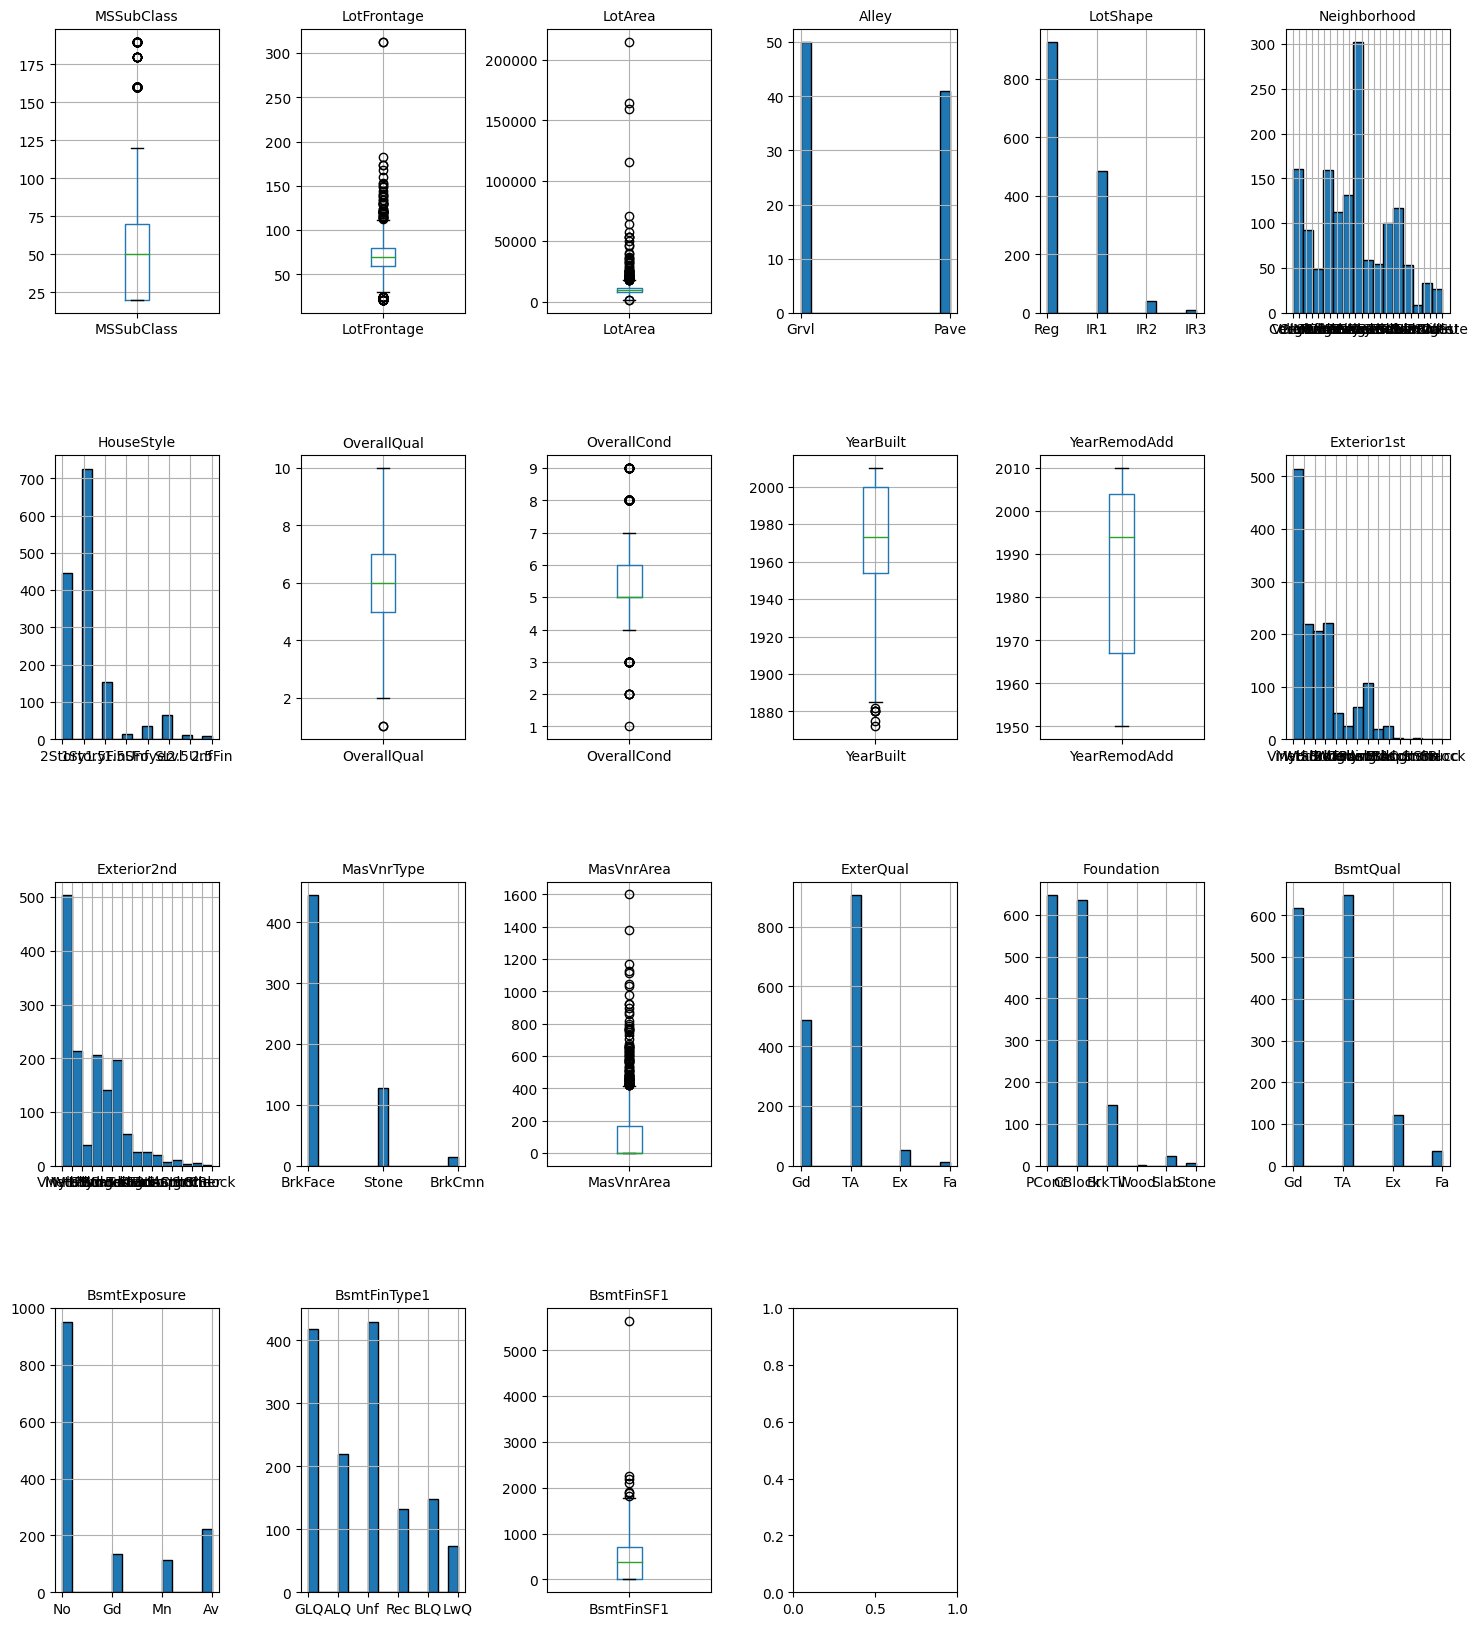

In [9]:
pre3 = pre2.copy()

# Calculate the proportion of the most frequent value for each column
proportion_threshold = 0.7
columns_to_drop = []

for column in pre3.columns:
    # Calculate the proportion of the most frequent value
    top_value_count = pre3[column].value_counts().max()
    top_value_proportion = top_value_count / len(pre3)
    
    # If the proportion is greater than the threshold, mark the column for dropping
    if top_value_proportion > proportion_threshold:
        columns_to_drop.append(column)

# Drop the identified columns from the DataFrame
pre3 = pre3.drop(columns=columns_to_drop)

print("Dropped columns:", columns_to_drop, "\n ")
print(len(columns_to_drop), " columns were dropped form the dataset.  \n ")
print(pre3.shape)


# Assuming 'test' is your DataFrame

# Set up the figure size and layout (adjust ncols and figsize as needed)
# Set up the figure size and layout (adjust ncols and figsize as needed)
fig, axes = plt.subplots(nrows=len(pre3.columns) // 6 + 1, ncols=6, figsize=(18, len(pre3.columns) * 1))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Iterate over columns and plot accordingly
for i, column in enumerate(pre3.columns):
    if (i>20): 
        break
    if pd.api.types.is_numeric_dtype(pre3[column]):
        # Plot box plot for numeric columns
        pre3.boxplot(column=column, ax=axes[i])
        axes[i].set_title(column, fontsize=10)
    else:
        # Convert column to string to handle mixed types and NaNs
        # test[column] = test[column].fillna('Missing').astype(str)
        # # Plot scatter plot for categorical columns
        # axes[i].scatter(x=test.index, y=test[column])
        # axes[i].set_title(column, fontsize=10)
        # axes[i].set_xlabel('Index')
        # axes[i].set_ylabel(column)
        pre3[column].hist(ax=axes[i], bins=15, edgecolor='black')
        axes[i].set_title(column, fontsize=10)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

As noticed from the univariate analysis above: <br> 

- On average there almost 60 linear feet of street connected to the properties. 
- Gravelled alleys are twice paved ones. 
- with a higher probability the pool quality will be excellent 

Regarding outliers I will deal with them later on when data analysis after the preprocessing stage. 

## 4. typos and misspelling 

In [10]:
# features are too many to check each and every one. Thus, I will try taking 3 samples which will let me know the overall typos or misspelling values 
pre4 = pre3.copy()
print(pre4['Exterior1st'].unique())
print(pre4['Fence'].unique())
print(pre4['HeatingQC'].unique())

pre4.shape
# seems like everything is fine 


['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CemntBd'
 'Plywood' 'AsbShng' 'Stucco' 'BrkComm' 'AsphShn' 'Stone' 'ImStucc'
 'CBlock']
[nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
['Ex' 'Gd' 'TA' 'Fa' 'Po']


(1460, 48)

## 5. missing values: 

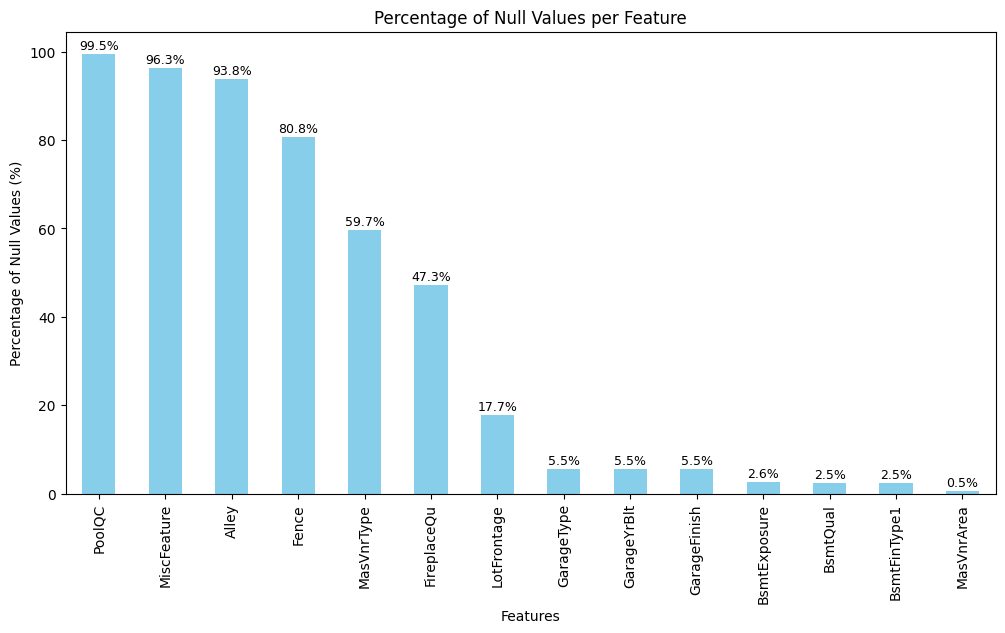

In [11]:
pre5 = pre4.copy()

# Calculate the percentage of null values for each feature
null_percentages = pre5.isnull().mean() * 100
null_percentages = null_percentages[null_percentages>0]
null_percentages = null_percentages.sort_values(ascending=False)

# Plot the histogram
plt.figure(figsize=(12, 6))
bars = null_percentages.plot(kind='bar', color='skyblue')

# Annotate the bars with the percentage value
for bar in bars.patches:
    bar_value = bar.get_height()
    text_position = bar_value + 1  # Position the text slightly above the bar
    bars.text(bar.get_x() + bar.get_width() / 2, text_position, f'{bar_value:.1f}%', ha='center', fontsize=9)

plt.title('Percentage of Null Values per Feature')
plt.xlabel('Features')
plt.ylabel('Percentage of Null Values (%)')
plt.xticks(rotation=90)  # Rotate the feature names for better readability
plt.show()

Idealy if the % of null values is less than 5%, we can delete the records ie., the rows or replace them with most frequent values. If the % of null values is greater than 60%- 70% (depending on data), we can delete the column containing the null values. <br>

However, this is the general case which is not the case in our data.... <br> 
Based on our data: 
- we cannot use forward or backward fill nor interpolation because dataset instances are independent of each other. 
- we cannot replace with a constant value because it will change the distribution of the vlaues in each feature 
- cannot use a machine learning model because as I said the data is unpredictable due it is dependency. 

Moreover, since, I have too many features of around 79 values thus, I ain't in need for the features with high percentage of nulll Values. 

Therefore, I will drop the cluster of features having null values of around 50% or more, and will replace null values for the features having null values less than 6% with the most repititive, frequent value. 

In [12]:
# test = prepro_data.copy()
pre5 = pre4.copy()
null_counts = pre5.isnull().mean()*100
print(pre5.shape, "\n\n **************** ")

# drop those features having null values more than 500 
columns_with_50nulls = null_counts[null_counts >= 45]
pre5 = pre5.drop(columns = columns_with_50nulls.index)
print("Those are the columns with null values almost greater than 50% to drop the whole feature column from the entire dataset: \n", columns_with_50nulls)
print(pre5.shape , "\n\n **************** ")


# Identify columns with fewer than 5 but more than 0 null values
columns_with_nulls = null_counts[(null_counts < 6) & (null_counts > 0)].index
# Either drop the rows 
# # test = test.dropna(subset = columns_with_nulls)
# Or fill them with the most repetitive value in the column which is more preferable to not decrease the dataset. 
for column in columns_with_nulls:
    pre5[column].fillna(pre5[column].mode()[0], inplace=True)
# columns_with_nulls = columns_with_nulls[columns_with_nulls > 0]
print("Those are the columns with null values almost less than 5% \nI replaced with the mode imputation (most repetitive value in the column): \n\n", columns_with_nulls)
print(pre5.shape, " \n\n ************ ")

# 
null_counts = pre5.isnull().sum()
null_counts = null_counts[null_counts > 0]
print(pre5.shape, null_counts)
        


(1460, 48) 

 **************** 
Those are the columns with null values almost greater than 50% to drop the whole feature column from the entire dataset: 
 Alley          93.767123
MasVnrType     59.726027
FireplaceQu    47.260274
PoolQC         99.520548
Fence          80.753425
MiscFeature    96.301370
dtype: float64
(1460, 42) 

 **************** 
Those are the columns with null values almost less than 5% 
I replaced with the mode imputation (most repetitive value in the column): 

 Index(['MasVnrArea', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'GarageType',
       'GarageYrBlt', 'GarageFinish'],
      dtype='object')
(1460, 42)  

 ************ 
(1460, 42) LotFrontage    259
dtype: int64


For the rest of the null values the remaining column, lets discuss what options we might come up with and use. 
- we cannot use forward or backward fill nor interpolation because dataset instances are independent of each other. 
- we cannot replace with a constant value because it will change the distribution of the vlaues in each feature 
- cannot use a machine learning model because as I said the data is unpredictable due it is dependency. 

**better options to consider**
- **replace values from another column (depend on the dependence of these columns on each other. )**
    - Lets view the correlation between this column and others. 
- **replace with random values. (prefer to use for all columns because they have a reasonable number of null values except for the lotFrontage column feature)**
    - try to keep the random values in an acceptable range, median range.

In [13]:
# lets see the correlation between this column and the rest of featuers. 
pre5_1 = pre5.copy()

# print('correletion between LotFrontage and target feature, price, is: ', pre5_1['SalePrice'].corr(pre5_1['LotFrontage']))
# print('')

# Calculate the correlation between 'feature_1' and the rest of the features
correlations = pre5_1.corr(numeric_only=True)['SalePrice'].drop('SalePrice')

# Sort the correlations in descending order
sorted_correlations = correlations.sort_values(ascending=False)

# Print the sorted correlations
print(f"Correlations between 'SalePrice' and other features, sorted in descending order:\n")
print(sorted_correlations)


Correlations between 'SalePrice' and other features, sorted in descending order:

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.472614
Fireplaces      0.466929
GarageYrBlt     0.397778
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
LotArea         0.263843
BsmtFullBath    0.227122
BsmtUnfSF       0.214479
BedroomAbvGr    0.168213
MoSold          0.046432
YrSold         -0.028923
OverallCond    -0.077856
MSSubClass     -0.084284
Name: SalePrice, dtype: float64


LotFrontage is from the top 15 features having good correletaion with the target features, SalePrice. <br>

Lets view the the correlation between LotFrontage and other features to see the possibility of filling the null values depending on this correlation 

In [14]:
pre5_2 = pre5_1.copy()

# Calculate the correlation between 'feature_1' and the rest of the features
correlations = pre5_2.corr(numeric_only=True)['LotFrontage'].drop('LotFrontage')

# Sort the correlations in descending order
sorted_correlations = correlations.sort_values(ascending=False)

# Print the sorted correlations
print(f"Correlations between 'LotFrontage' and other features, sorted in descending order:\n")
print(sorted_correlations)

Correlations between 'LotFrontage' and other features, sorted in descending order:

1stFlrSF        0.457181
LotArea         0.426095
GrLivArea       0.402797
TotalBsmtSF     0.392075
TotRmsAbvGrd    0.352096
SalePrice       0.351799
GarageArea      0.344997
GarageCars      0.285691
Fireplaces      0.266639
BedroomAbvGr    0.263170
OverallQual     0.251646
BsmtFinSF1      0.233633
FullBath        0.198769
MasVnrArea      0.192411
OpenPorchSF     0.151972
BsmtUnfSF       0.132644
YearBuilt       0.123349
BsmtFullBath    0.100949
YearRemodAdd    0.088866
WoodDeckSF      0.088521
2ndFlrSF        0.080177
HalfBath        0.053532
GarageYrBlt     0.040788
MoSold          0.011200
YrSold          0.007450
OverallCond    -0.059213
MSSubClass     -0.386347
Name: LotFrontage, dtype: float64


There is a good, logical correletion between lotfrontage and lotarea, thus, lets do some missing values filling based on the correlation between those two columns 

In [15]:
pre5_3 = pre5_2.copy()

nulls = pre5_3.isnull().sum()
nulls = nulls[nulls>0]
print("null values before filling them \n ->",nulls)
print("shape before: ", pre5_3.shape, " \n \n ***********************")

pre5_3['LotFrontage'] = pre5_3['LotFrontage'].fillna(pre5_3['LotArea'])

nulls = pre5_3.isnull().sum()
nulls = nulls[nulls>0]
print("null values after filling them",nulls)
print("shape after: ", pre5_3.shape)


null values before filling them 
 -> LotFrontage    259
dtype: int64
shape before:  (1460, 42)  
 
 ***********************
null values after filling them Series([], dtype: int64)
shape after:  (1460, 42)


In [16]:
# finally lets view the overall difference between the row data and the preprocessed data: 
print(row_data.shape)
print(pre5_3.shape)

# print()

(1460, 81)
(1460, 42)


As you can see, not a single row was removed which is very helpful for my training on huge data instances. however, I have filtered the columns, features, deeply and that was needed especially before the model usage stage which will require at most 30 features to exist in the table. <br> <br>
At this point I am done with independent preprocessing (Data cleaning)

---
# Preprocessing Stage2 (dependent on Target feature): 

1. Feature selection using different methods: 
    - correletion with the target feature (for more info look at the table made in the google doc)
        - Pearson’s correlation coefficient
        - Spearman’s correlation coefficient
        - Kendall’s Tau
        - boruta algorithm

2. Categorical Variables: 
    - One-hot encoding (most used) - Frequency encoding - hash encoding - label encoding

3. Dropping outliers: 
    - numerical
    - categorical
    - mixed

4. ----- Data Analysis -----: 
    - Univariate Analysis. 
    - Multivariate Analysis. 

4. numerical features: 
    - rounding
    - Binning (bucketing)
    - Scaling
        - standard Z scaling (most used) - minMax scaling - log scaling - instance-based learning



Side note: removing outliers should be before scaling or standardization. 
---

## 1. Feature Selection
Based on all possible correlationship algorithms we have, boruta is the most suitable to be used for the following reasons
- Handles Both Feature Types: Categorical, numerical 
- Prevents Overfitting

In [17]:

# Assuming you have a DataFrame 'df' and the target column is 'SalePrice'
pre21 = pre5_3.copy()
X = pre21.drop(columns=['SalePrice'])
y = pre21['SalePrice']

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

# Initialize Boruta with a Random Forest Regressor
rf = RandomForestRegressor(n_jobs=-1, max_depth=7, n_estimators=1000, random_state=42)
# boruta parameters. 
boruta = BorutaPy(rf, n_estimators='auto', random_state=42, max_iter=100)

# Fit Boruta
boruta.fit(X_encoded.values, y.values)

# Select the top 25-30 features
selected_features = X_encoded.columns[boruta.support_].to_list()
print("Selected features to exist in the data: \n", selected_features)
print("they are: ", len(selected_features), " features \n")


listt = []
for feature in selected_features: 
    if '_' in feature: 
        temp = feature.split('_')
        listt.append(temp[0])
    else: 
        listt.append(feature)
listt


pre21 = pre21[listt + ['SalePrice']]


Selected features to exist in the data: 
 ['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'GarageFinish_Unf']
they are:  16  features 



In [18]:
numerical_features = pre21.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = pre21.select_dtypes(include=['object', 'category']).columns.tolist()
print( len(numerical_features), "Numerical Features:", numerical_features, "\n", len(categorical_features),"Categorical Features:", categorical_features)

16 Numerical Features: ['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'SalePrice'] 
 1 Categorical Features: ['GarageFinish']


#### recommendation: 
an optional research and debug boruta algorithm <br>
kaggle notebooks using boruta & debug more in teh details of hte algorithm 

## 2. Categorical Variables: 
One-hot encoding (most used) - Frequency encoding - hash encoding - label encoding

In [19]:
pre22 = pre21.copy()

# preferably use one-hot encoding because I am only concerned with only one value 
# in the Garage finished which is the unfinished one. 
# And that is based on the output of the burota algorithm
pre22 = pd.get_dummies(pre22, drop_first=True)
pre22 = pre22.drop(columns = 'GarageFinish_RFn')

pre22

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,SalePrice,GarageFinish_Unf
0,8450,7,5,2003,2003,196.0,706,856,856,854,1710,2,8,2,548,208500,False
1,9600,6,8,1976,1976,0.0,978,1262,1262,0,1262,2,6,2,460,181500,False
2,11250,7,5,2001,2002,162.0,486,920,920,866,1786,2,6,2,608,223500,False
3,9550,7,5,1915,1970,0.0,216,756,961,756,1717,1,7,3,642,140000,True
4,14260,8,5,2000,2000,350.0,655,1145,1145,1053,2198,2,9,3,836,250000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,7917,6,5,1999,2000,0.0,0,953,953,694,1647,2,7,2,460,175000,False
1456,13175,6,6,1978,1988,119.0,790,1542,2073,0,2073,2,7,2,500,210000,True
1457,9042,7,9,1941,2006,0.0,275,1152,1188,1152,2340,2,9,1,252,266500,False
1458,9717,5,6,1950,1996,0.0,49,1078,1078,0,1078,1,5,1,240,142125,True


## 3. Dropping outliers: 


In [20]:
pre23 = pre22.copy()

# Calculate the Z-scores for numerical features
z_scores = np.abs(stats.zscore(pre23.select_dtypes(include=[np.number])))

# Define a threshold for identifying outliers
threshold = 3

# Create a boolean mask to filter out rows with any Z-score above the threshold
outlier_mask = (z_scores < threshold).all(axis=1)

# Apply the mask to remove outliers
pre23 = pre23[outlier_mask]

print("shape before 2nd stage of preprocessing: ", pre5_3.shape)
print("shape after feature_selection and dropping outliers: ", pre23.shape)


shape before 2nd stage of preprocessing:  (1460, 42)
shape after feature_selection and dropping outliers:  (1351, 17)


From the previous output you can view that the data is now precessed and ready for analysis. Lets download this part of data to easily load them again easily for more deeper analysis. 


In [25]:
# pre23.to_csv('house_prices_ready_analysis_stage23.csv')
# 

## 4. 1. Univariate Analysis

C:\Users\monee\AppData\Local\Temp\ipykernel_18172\228495964.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.0)
C:\Users\monee\AppData\Local\Temp\ipykernel_18172\228495964.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.0)


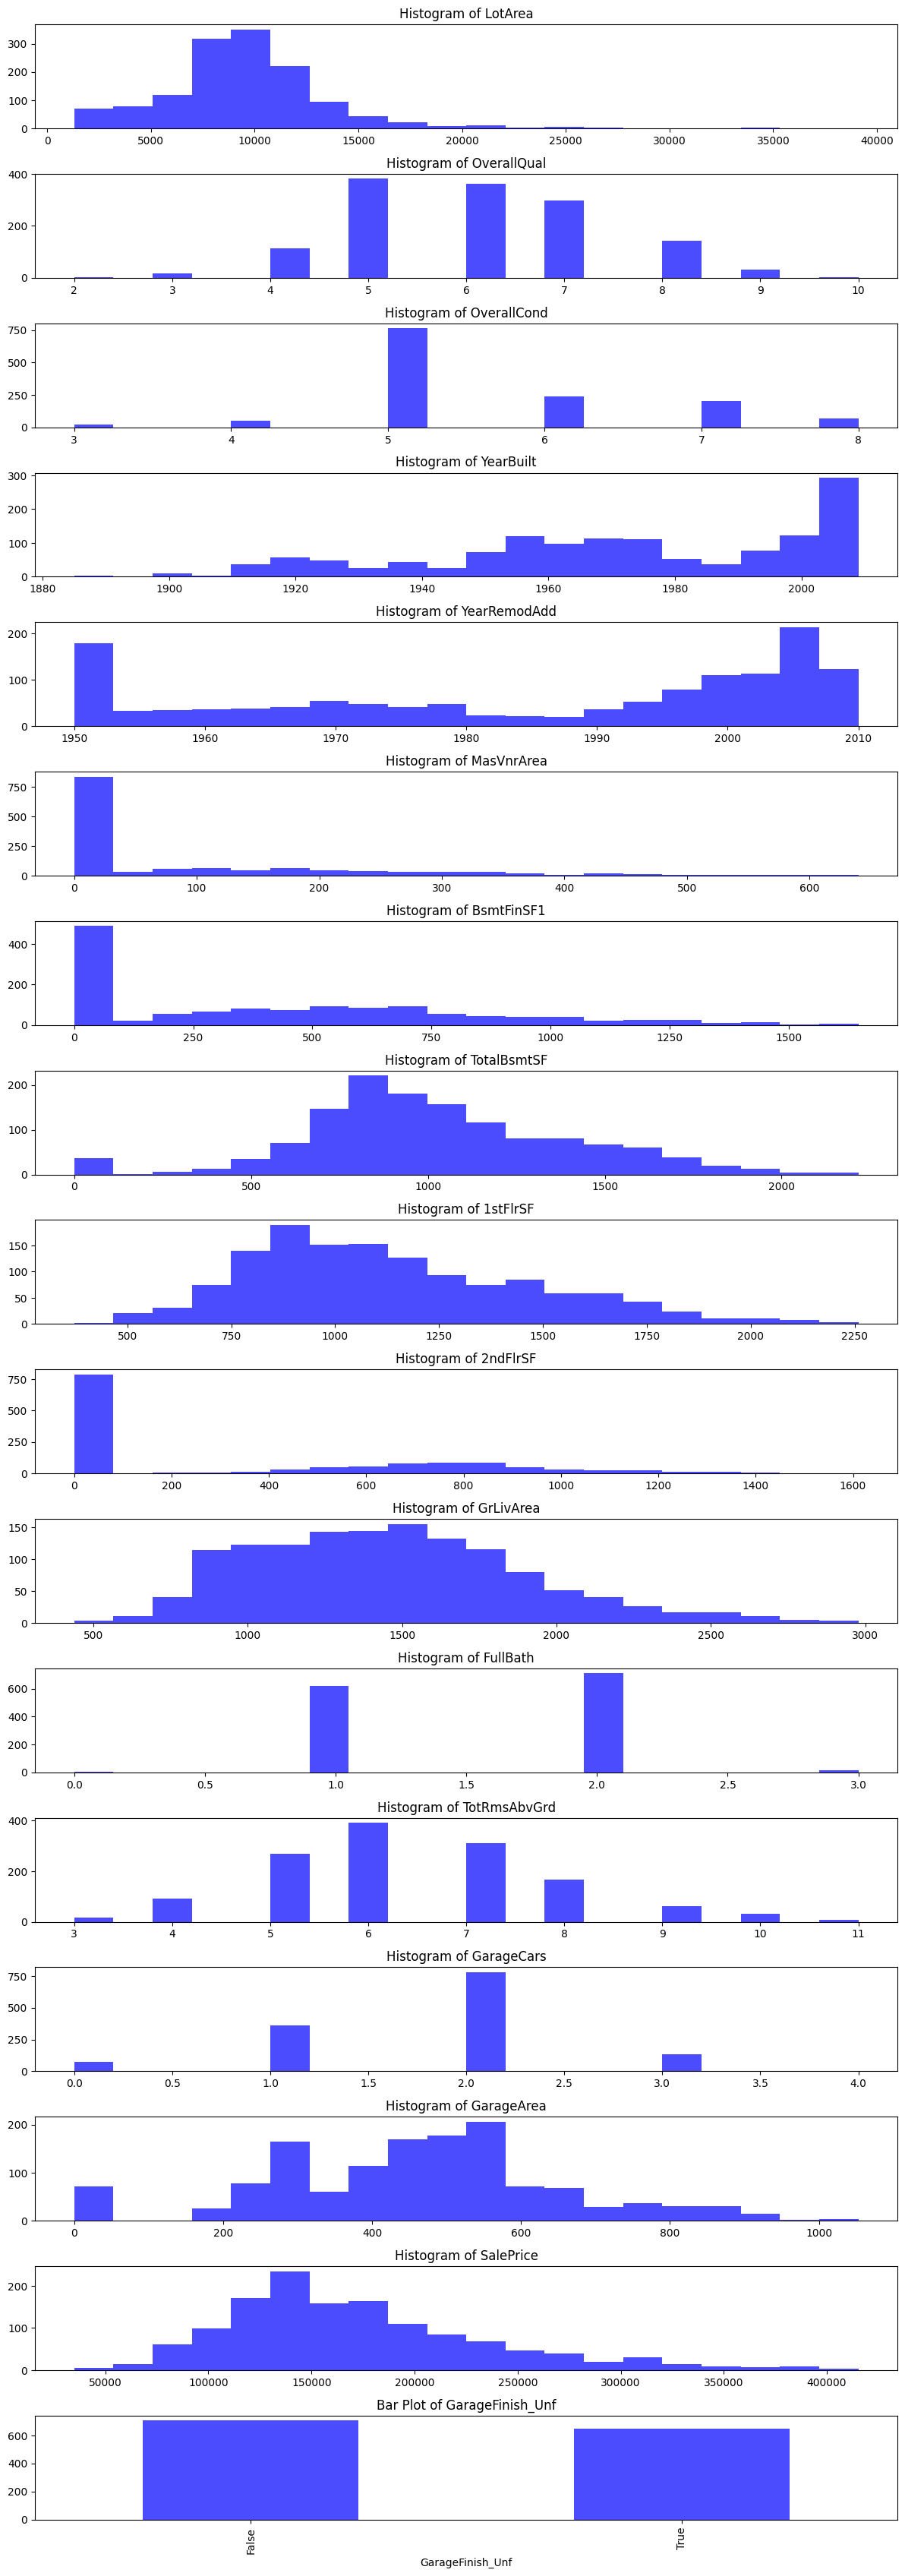

In [21]:
pre24_1 = pre23.copy()
# Assuming pre24_1 is already defined
# Number of features
num_features = pre24_1.shape[1]

# Set up the plotting grid
plt.figure(figsize=(12, num_features * 2))

# Loop through each feature and create a histogram
for i, column in enumerate(pre24_1.columns):
    plt.subplot(num_features, 1, i + 1)
    
    # Check if the column is boolean
    if pre24_1[column].dtype == 'bool':
        pre24_1[column].value_counts().plot(kind='bar', color='blue', alpha=0.7)
        plt.title(f'Bar Plot of {column}')
    else:
        plt.hist(pre24_1[column], bins=20, color='blue', alpha=0.7)
        plt.title(f'Histogram of {column}')
    
    plt.tight_layout(pad=1.0)

plt.show()


As noticed: 
- most of the houses areas are around 10000 Square feet which is substantial and can provide ample space for building a family home with a decent-sized yard and a pool, depending on your local zoning regulations and how you choose to use the space. 
- the overall quality and condition of most houses are 5 or 6 out of 10 (average quality).
- Most of the houses are built or remodelled after the year 2000 
- with a high percentage houses does not have MasVnrArea 

## 4. 2. Multivariate Analysis

In [1]:
pre24_2 = pre23.copy()

# Set up the plotting grid
plt.figure(figsize=(14, 10))

# Set up the plotting grid for 2 histograms
plt.figure(figsize=(14, 6))

# 1. Histogram for SalePrice vs. YearBuilt
plt.subplot(1, 2, 1)
plt.hist(pre24_1['YearBuilt'], bins=200, color='blue', alpha=0.7)
plt.xlabel('YearBuilt')
plt.ylabel('SalePrice')
plt.title('Histogram: YearBuilt vs. SalePrice')

# 2. Histogram for SalePrice vs. YearRemodAdd
plt.subplot(1, 2, 2)
plt.hist(pre24_1['YearRemodAdd'], bins=200, color='green', alpha=0.7)
plt.xlabel('YearRemodAdd')
plt.ylabel('SalePrice')
plt.title('Histogram: YearRemodAdd vs. SalePrice')

plt.tight_layout(pad=3.0)
plt.show()



NameError: name 'pre23' is not defined

## 5. Numerical Features: 
- rounding
- Binning (bucketing)
- Scaling
    - standard Z scaling (most used) - minMax scaling - log scaling - instance-based learning

In [73]:
pre23 = pre22.copy()

# Assume 'boolean_column' is the name of your boolean column
boolean_column = 'GarageFinish_Unf'

# Separate the boolean column and numerical features
boolean_data = pre23[boolean_column]
numerical_data = pre23.drop(columns=[boolean_column])

# Apply Z-score scaling to numerical features
scaler = StandardScaler()
scaled_numerical_data = pd.DataFrame(scaler.fit_transform(numerical_data), columns=numerical_data.columns)

# Combine the scaled numerical features and the boolean column
pre23 = pd.concat([scaled_numerical_data, boolean_data.reset_index(drop=True)], axis=1)

pre23


,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,SalePrice,GarageFinish_Unf
0,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.514104,0.575425,-0.459303,-0.793434,1.161852,0.370333,0.789741,0.912210,0.311725,0.351000,0.347273,False
1,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.570750,1.171992,0.466465,0.257140,-0.795163,-0.482512,0.789741,-0.318683,0.311725,-0.060731,0.007288,False
2,0.073480,0.651479,-0.517200,0.984752,0.830215,0.325915,0.092907,-0.313369,-0.627826,1.189351,0.515013,0.789741,-0.318683,0.311725,0.631726,0.536154,False
3,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.570750,-0.499274,-0.687324,-0.521734,0.937276,0.383659,-1.026041,0.296763,1.650307,0.790804,-0.515281,True
4,0.375148,1.374795,-0.517200,0.951632,0.733308,1.366489,0.463568,0.199680,-0.045611,1.617877,1.299326,0.789741,1.527656,1.650307,1.698485,0.869843,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,-0.260560,-0.071836,-0.517200,0.918511,0.733308,-0.570750,-0.973018,-0.238122,-0.542435,0.795198,0.250402,0.789741,0.296763,0.311725,-0.060731,-0.074560,False
1456,0.266407,-0.071836,0.381743,0.222975,0.151865,0.087911,0.759659,1.104925,2.355701,-0.795163,1.061367,0.789741,0.296763,0.311725,0.126420,0.366161,True
1457,-0.147810,0.651479,3.078570,-1.002492,1.024029,-0.570750,-0.369871,0.215641,0.065656,1.844744,1.569647,0.789741,1.527656,-1.026858,-1.033914,1.077611,False
1458,-0.080160,-0.795151,0.381743,-0.704406,0.539493,-0.570750,-0.865548,0.046905,-0.218982,-0.795163,-0.832788,-1.026041,-0.934130,-1.026858,-1.090059,-0.488523,True


As you can see from the previous output: 
- the differece in features, and columns, is due to boruta algorithm. 
- The difference in rows is due to removing outliers. 


Finally, the data is ready for model choice and training: 

# Done